## Plot SynapseCLR training loss function

- The first stage is initialized with random weights and is trained for 100 epochs
- The second stage is initialized to the last checkpoint from the first stage (restart) and is trained for another 100 epochs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from torchinfo import summary
import torch

from scipy.signal import savgol_filter

from synapse_simclr.modules import generate_resnet_3d
from synapse_simclr.modules.projector import Projector

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

checkpoint_path_list = [
    '../../output/checkpoint__synapseclr__so3__first_stage',
    '../../output/checkpoint__synapseclr__so3__second_stage']

## Plot NTXent loss

../../output/checkpoint__synapseclr__so3__first_stage
../../output/checkpoint__synapseclr__so3__second_stage


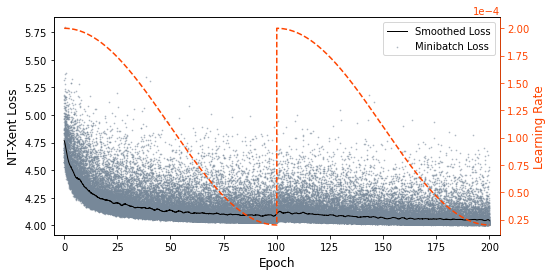

In [3]:
loss_list = []

ctr = 1
minibatch_per_epoch = None
for checkpoint_path in checkpoint_path_list:
    print(checkpoint_path)
    while True:
        try:
            loss_list_chunk = np.load(
                os.path.join(checkpoint_path, f'loss_list_{ctr}.npy')).tolist()
            minibatch_per_epoch = len(loss_list_chunk)
            loss_list += loss_list_chunk
            ctr += 1
        except IOError:
            ctr = 1
            break
        
fig = plt.figure(figsize=(8, 4))
ax = plt.gca()

x = np.arange(len(loss_list))

x = np.arange(len(loss_list)) / minibatch_per_epoch
x = 200 * x / x[-1]
y = np.asarray(loss_list)
y_smooth = savgol_filter(y, 3001, 5)

ax.scatter(x, y, s=0.5, alpha=0.5, color='lightslategray', label='Minibatch Loss', rasterized=True)
ax.plot(x, y_smooth, color='black', lw=1, label='Smoothed Loss')
ax.set_xlim((-5, 205))

ax.set_xlabel('Epoch')
ax.set_ylabel('NT-Xent Loss')

ax2 = ax.twinx()

n_repeats = 2
n_epochs_per_repeat = 100
lr_max = 2e-4
lr_min = 2e-5

x_list = []
lr_list = []

for i_repeat in range(n_repeats):
    x = np.linspace(0, n_epochs_per_repeat, 10000)
    lr = lr_min + 0.5 * (lr_max - lr_min) * (np.cos(x * np.pi / n_epochs_per_repeat) + 1)
    x_list.append(x + i_repeat * n_epochs_per_repeat)
    lr_list.append(lr)
    
x = np.concatenate(x_list)
lr = np.concatenate(lr_list)

line = ax2.plot(x, lr, color='orangered', linestyle='--', label='Learning Rate')

ax2.yaxis.label.set_color(line[0].get_color())
ax2.spines["right"].set_edgecolor(line[0].get_color())
ax2.spines["right"].set_edgecolor(line[0].get_color())
ax2.tick_params(axis='y', colors=line[0].get_color())
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_ylabel('Learning Rate')
ax2.set_ylim((1.1e-5, 2.1e-4))
ax.legend()

fig.savefig('../../output/analysis/loss/synapse_simclr_loss.pdf', bbox_inches='tight', dpi=300)

## SynapseCLR Network Parameters

In [4]:
resnet = generate_resnet_3d(
    model_depth=18,
    n_input_channels=1,
    no_max_pool=True,
    conv1_kernel_size=7,
    conv1_stride=2,
    conv1_padding=3).to(torch.device("cpu"))

summary(resnet, (1, 96, 96, 96), batch_dim=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 400]                  --
├─Conv3d: 1-1                            [1, 64, 48, 48, 48]       21,952
├─BatchNorm3d: 1-2                       [1, 64, 48, 48, 48]       128
├─ReLU: 1-3                              [1, 64, 48, 48, 48]       --
├─MaxPool3d: 1-4                         --                        --
├─Sequential: 1-5                        [1, 64, 48, 48, 48]       --
│    └─BasicBlock: 2-1                   [1, 64, 48, 48, 48]       --
│    │    └─Conv3d: 3-1                  [1, 64, 48, 48, 48]       110,592
│    │    └─BatchNorm3d: 3-2             [1, 64, 48, 48, 48]       128
│    │    └─ReLU: 3-3                    [1, 64, 48, 48, 48]       --
│    │    └─Conv3d: 3-4                  [1, 64, 48, 48, 48]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 48, 48, 48]       128
│    │    └─ReLU: 3-6                    [1, 64, 48, 48, 48]       -

In [5]:
proj = Projector(512, [512, 128])

summary(proj, (512,), batch_dim=0, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Projector                                [1, 512]                  --
├─Sequential: 1-1                        --                        --
│    └─Linear: 2-1                       [1, 512]                  262,144
│    └─BatchNorm1d: 2-2                  [1, 512]                  1,024
│    └─ReLU: 2-3                         [1, 512]                  --
│    └─Linear: 2-4                       [1, 128]                  65,536
Total params: 328,704
Trainable params: 328,704
Non-trainable params: 0
Total mult-adds (M): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.31
Estimated Total Size (MB): 1.33